In [1]:
import json, os, torch, sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import seaborn as sns
import FoFCatalogMatching
import pycocotools.mask as mask_util
from multiprocessing import Pool
from functools import partial
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table
import pycocotools.mask as mask_util
# detectron2 and deepdisc
from detectron2.config import LazyConfig
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import Instances, Boxes
from deepdisc.astrodet.visualizer import Visualizer, ColorMode
from deepdisc.data_format.register_data import register_data_set
from custom.mappers import FileNameWCSMapper

In [2]:
root_dir = os.path.expanduser('~/lsst_data/')
root_run_dir = os.path.expanduser('~/lsst_runs/')
folder = 'annotations_lvl5'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_cats_dir = f'{root_dir}test_cats_lvl5/test_8k/'
test_data = pd.read_json(test_data_fn)
run_name = 'lsst5_30k_4h200_bs192_ep50'
run_dir = f'{root_run_dir}{run_name}/'
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")
print(f"Run name: {run_name} and run dir: {run_dir}")

Loaded test data from /u/yse2/lsst_data/annotations_lvl5/test_8k.json with 8571 images.
Run name: lsst5_30k_4h200_bs192_ep50 and run dir: /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/


In [3]:
cfg_file = os.path.expanduser("~/deepdisc/configs/solo/swin_lsst_job.py")
cfg = LazyConfig.load(cfg_file) # using a Swin Transformer
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

cfg.DATASETS.TEST = "test"
cfg.dataloader.augs = None # no augs for test set since we want preds on OG images
cfg.dataloader.test.mapper = FileNameWCSMapper # setting test DataLoader's mapper so that filename gets added to each sample
print(f"Config loaded successfully!")
print(f"Registering training dataset from: {test_data_fn}")
try:
    DatasetCatalog.remove(cfg.DATASETS.TEST)
    MetadataCatalog.remove(cfg.DATASETS.TEST)
except:
    pass
custom_colors = [
    (0, 255, 0),    # green for galaxies
    (0, 0, 255),    # blue for stars
]
astrotest_metadata = register_data_set(
    cfg.DATASETS.TEST, test_data_fn, thing_classes=cfg.metadata.classes, thing_colors=custom_colors
)
test_score_thresh = 0.25
nms_thresh = 0.5
print(f"Dataset registered successfully!")
print(f"Test Score Threshold: {test_score_thresh}")
print(f"NMS Threshold: {nms_thresh}")

Config loaded successfully!
Registering training dataset from: /u/yse2/lsst_data/annotations_lvl5/test_8k.json
Dataset registered successfully!
Test Score Threshold: 0.25
NMS Threshold: 0.5


In [4]:
buffers = [1, 2]
mag_limits = {
    'power_law': 26.07,
    'gold': 25.3,
    'nominal': 26.42,
}

In [5]:
truth_mag_limit = mag_limits['gold'] + buffers[0]
truth_fn = f'{test_cats_dir}test_truth_cat_maglim_{truth_mag_limit:.2f}.parquet'
# truth_fn = f'/u/yse2/lsst_runs/{run_name}/test_cats/full_test_truth_cat.parquet'
print(f'Loading LSST truth catalog from: {truth_fn}')
lsst_truth_cat = pd.read_parquet(truth_fn)

Loading LSST truth catalog from: /u/yse2/lsst_data/test_cats_lvl5/test_8k/test_truth_cat_maglim_26.30.parquet


In [6]:
pred_fn = f'{run_dir}preds/pred_with_mag_s{test_score_thresh}_n{nms_thresh}.json'
with open(pred_fn, 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)

In [7]:
lsst_det_cat = pd.read_json(f'{test_cats_dir}test_det_cat.json')

In [12]:
# skip here to re-load saved results (but make sure to set truth_mag_limit correctly)
analysis = {}
counts = {}
all_matches = {
    '0.5': {},
    '1.0': {}
}
for ll in ['0.5', '1.0']:
    analysis[ll] = pd.read_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/analysis{ll}_{truth_mag_limit}.parquet')
    counts[ll] = pd.read_parquet(f'{run_dir}grp_class{ll}_{truth_mag_limit}.parquet')
    all_matches[ll]['dd'] = pd.read_parquet(f'{run_dir}obj_matches_dd{ll}_{truth_mag_limit}.parquet')
    all_matches[ll]['lsst'] = pd.read_parquet(f'{run_dir}obj_matches_lsst{ll}_{truth_mag_limit}.parquet')

# Object-Level Detection Completeness
Now that we have all object-level match records, we can calculate detection completeness
metrics. Object-level completeness measures the fraction of individual truth objects
that were successfully detected and matched. We calculate the fraction of truth objects that were successfully matched to detections.

In [13]:
def calculate_object_completeness(object_matches, prefix='dd'):
    """
    Calculate object-level detection completeness (recall).
    
    Args:
        object_matches: DataFrame with object-level match records
        prefix: 'dd' or 'lsst'
    
    Returns:
        dict: Completeness statistics
    """
    # Filter to truth objects only (exclude spurious detections where truth_row_idx == -1)
    truth_objects = object_matches[object_matches['truth_row_idx'] != -1].copy()
    # Each truth object should appear exactly once in the match records
    # (either matched or unmatched)
    truth_objects_unique = truth_objects.drop_duplicates(subset='truth_row_idx')
    
    # Count matched vs total
    total_truth = len(truth_objects_unique)
    matched_truth = truth_objects_unique['matched'].sum()
    unmatched_truth = total_truth - matched_truth
    
    completeness = matched_truth / total_truth if total_truth > 0 else 0.0
    
    return {
        'total_truth': total_truth,
        'matched_truth': matched_truth,
        'unmatched_truth': unmatched_truth,
        'completeness': completeness
    }

In [14]:
print("OBJECT-LEVEL DETECTION COMPLETENESS")
completeness_results = {}

for ll in ['0.5', '1.0']:
    print(f"\n{'='*60}")
    print(f"Linking Length {ll}\"")
    print(f"{'='*60}\n")
    
    completeness_results[ll] = {}
    
    # DD Completeness
    print(f"--- DeepDISC Completeness ---")
    dd_stats = calculate_object_completeness(all_matches[ll]['dd'], 'dd')
    completeness_results[ll]['dd'] = dd_stats
    
    print(f"Total truth objects:     {dd_stats['total_truth']:,}")
    print(f"Matched truth objects:   {dd_stats['matched_truth']:,}")
    print(f"Unmatched truth objects: {dd_stats['unmatched_truth']:,}")
    print(f"Completeness (Recall):   {dd_stats['completeness']:.2%}\n")
    
    # LSST Completeness
    print(f"--- LSST Pipeline Completeness ---")
    lsst_stats = calculate_object_completeness(all_matches[ll]['lsst'], 'lsst')
    completeness_results[ll]['lsst'] = lsst_stats
    
    print(f"Total truth objects:     {lsst_stats['total_truth']:,}")
    print(f"Matched truth objects:   {lsst_stats['matched_truth']:,}")
    print(f"Unmatched truth objects: {lsst_stats['unmatched_truth']:,}")
    print(f"Completeness (Recall):   {lsst_stats['completeness']:.2%}\n")
    
    # Comparison
    diff = dd_stats['completeness'] - lsst_stats['completeness']
    print(f"--- Comparison ---")
    print(f"DeepDISC advantage: {diff:+.2%} ({diff*100:+.1f} percentage points)\n")

print(f"{'='*80}\n")

OBJECT-LEVEL DETECTION COMPLETENESS

Linking Length 0.5"

--- DeepDISC Completeness ---
Total truth objects:     224,192
Matched truth objects:   182,507
Unmatched truth objects: 41,685
Completeness (Recall):   81.41%

--- LSST Pipeline Completeness ---
Total truth objects:     224,192
Matched truth objects:   185,678
Unmatched truth objects: 38,514
Completeness (Recall):   82.82%

--- Comparison ---
DeepDISC advantage: -1.41% (-1.4 percentage points)


Linking Length 1.0"

--- DeepDISC Completeness ---
Total truth objects:     224,192
Matched truth objects:   197,391
Unmatched truth objects: 26,801
Completeness (Recall):   88.05%

--- LSST Pipeline Completeness ---
Total truth objects:     224,192
Matched truth objects:   187,125
Unmatched truth objects: 37,067
Completeness (Recall):   83.47%

--- Comparison ---
DeepDISC advantage: +4.58% (+4.6 percentage points)




# Completeness by Magnitude
Calculate completeness separately for different mag bins to understand how detection performance varies with object magnitude.

In [45]:
def calculate_comp_by_mag(object_matches, truth_catalog, prefix='dd', n_bins=8):
    """
    Calculate completeness stratified by magnitude bins.
    
    Args:
        object_matches: DataFrame with object-level match records
        truth_catalog: Truth catalog with magnitude information
        prefix: 'dd' or 'lsst'
        n_bins: Number of magnitude bins (default 8 to match original [14,22,23,24,25,26,27,28])
    
    Returns:
        DataFrame with completeness per magnitude bin
    """
    # Filter to truth objects only
    truth_matches = object_matches[object_matches['truth_row_idx'] != -1].copy()
    # Drop duplicates to get unique truth objects
    truth_matches_unique = truth_matches.drop_duplicates(subset='truth_row_idx')
    
    # Join with truth catalog to get magnitudes
    truth_with_mags = truth_matches_unique.merge(
        truth_catalog[['mag_i']],
        left_on='truth_row_idx',
        right_index=True,
        how='left'
    )
    
    # Create magnitude bins using linspace from min to max
    mag_min = truth_catalog['mag_i'].min() + 7
    mag_max = truth_catalog['mag_i'].max()
    mag_bins = np.linspace(mag_min, mag_max, n_bins + 1)
    
    # Create magnitude bins
    truth_with_mags['mag_bin'] = pd.cut(
        truth_with_mags['mag_i'],
        bins=mag_bins,
        labels=[f"{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}" for i in range(len(mag_bins)-1)],
        include_lowest=True
    )
    
    # Calculate completeness per bin
    completeness_by_bin = []
    for mag_bin in truth_with_mags['mag_bin'].cat.categories:
        bin_data = truth_with_mags[truth_with_mags['mag_bin'] == mag_bin]
        
        if len(bin_data) > 0:
            n_total = len(bin_data)
            n_matched = bin_data['matched'].sum()
            completeness = n_matched / n_total
            
            completeness_by_bin.append({
                'mag_bin': mag_bin,
                'n_total': n_total,
                'n_matched': n_matched,
                'completeness': completeness
            })
    
    return pd.DataFrame(completeness_by_bin)


In [46]:
print(f"\n{'='*80}")
print("COMPLETENESS BY MAGNITUDE")
print(f"{'='*80}\n")
mag_comp = {}

for ll in ['0.5', '1.0']:
    print(f"\n{'='*60}")
    print(f"Linking Length {ll}\"")
    print(f"{'='*60}\n")
    
    mag_comp[ll] = {}
    # DD Completeness by Magnitude
    print(f"--- DeepDISC Completeness by Magnitude ---")
    dd_mag = calculate_comp_by_mag(all_matches[ll]['dd'], lsst_truth_cat, 'dd')
    mag_comp[ll]['dd'] = dd_mag
    
    for _, row in dd_mag.iterrows():
        print(f"mag_i {row['mag_bin']}: {row['completeness']:.2%} ({row['n_total']:,} objects)")
    
    # LSST Completeness by Magnitude
    print(f"\n--- LSST Pipeline Completeness by Magnitude ---")
    lsst_mag = calculate_comp_by_mag(all_matches[ll]['lsst'], lsst_truth_cat, 'lsst')
    mag_comp[ll]['lsst'] = lsst_mag
    
    for _, row in lsst_mag.iterrows():
        print(f"mag_i {row['mag_bin']}: {row['completeness']:.2%} ({row['n_total']:,} objects)")


COMPLETENESS BY MAGNITUDE


Linking Length 0.5"

--- DeepDISC Completeness by Magnitude ---
mag_i 15.9-17.2: 29.52% (227 objects)
mag_i 17.2-18.5: 37.41% (417 objects)
mag_i 18.5-19.8: 47.67% (1,118 objects)
mag_i 19.8-21.1: 60.99% (3,166 objects)
mag_i 21.1-22.4: 71.40% (8,465 objects)
mag_i 22.4-23.7: 78.56% (19,691 objects)
mag_i 23.7-25.0: 84.51% (52,935 objects)
mag_i 25.0-26.3: 82.30% (137,967 objects)

--- LSST Pipeline Completeness by Magnitude ---
mag_i 15.9-17.2: 97.36% (227 objects)
mag_i 17.2-18.5: 97.36% (417 objects)
mag_i 18.5-19.8: 97.23% (1,118 objects)
mag_i 19.8-21.1: 97.25% (3,166 objects)
mag_i 21.1-22.4: 97.01% (8,465 objects)
mag_i 22.4-23.7: 94.73% (19,691 objects)
mag_i 23.7-25.0: 90.70% (52,935 objects)
mag_i 25.0-26.3: 76.72% (137,967 objects)

Linking Length 1.0"

--- DeepDISC Completeness by Magnitude ---
mag_i 15.9-17.2: 38.77% (227 objects)
mag_i 17.2-18.5: 48.44% (417 objects)
mag_i 18.5-19.8: 58.86% (1,118 objects)
mag_i 19.8-21.1: 72.77% (3,166 object

In [47]:
def plot_completeness_vs_magnitude(mag_comp, linking_lengths=['0.5', '1.0']):
    """
    Line plot showing how completeness degrades with magnitude.
    Works with the simpler calculate_comp_by_mag output.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    for idx, ll in enumerate(linking_lengths):
        ax = axes[idx]
        
        dd_data = mag_comp[ll]['dd']
        lsst_data = mag_comp[ll]['lsst']
        
        # Extract magnitude bin centers from bin labels (e.g., "22.5-23.8" -> 23.15)
        dd_data['mag_center'] = dd_data['mag_bin'].apply(
            lambda x: sum(map(float, str(x).split('-'))) / 2
        )
        lsst_data['mag_center'] = lsst_data['mag_bin'].apply(
            lambda x: sum(map(float, str(x).split('-'))) / 2
        )
        
        # Plot lines
        ax.plot(dd_data['mag_center'], dd_data['completeness'], 
                marker='o', linewidth=2, markersize=8, label='DeepDISC', color='#2E86AB')
        
        ax.plot(lsst_data['mag_center'], lsst_data['completeness'], 
                marker='s', linewidth=2, markersize=8, label='LSST Pipeline', color='#A23B72')
        
        # Reference lines
        ax.axhline(0.95, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='95% threshold')
        ax.axhline(0.50, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        
        ax.set_xlabel('$i$-band Magnitude', fontsize=12)
        ax.set_ylabel('Detection Completeness', fontsize=12)
        ax.set_title(f'Linking Length = {ll}″', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower left', fontsize=10)
        ax.set_ylim(0, 1.05)
        
        # Annotate sample sizes at first, middle, and last points
        for i in [0, len(dd_data)//2, len(dd_data)-1]:
            mag_val = dd_data.iloc[i]['mag_center']
            n = dd_data.iloc[i]['n_total']
            ax.text(mag_val, 0.02, f'n={n:,}', fontsize=8, ha='center', 
                   rotation=0, alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('completeness_vs_magnitude.png', dpi=300, bbox_inches='tight')

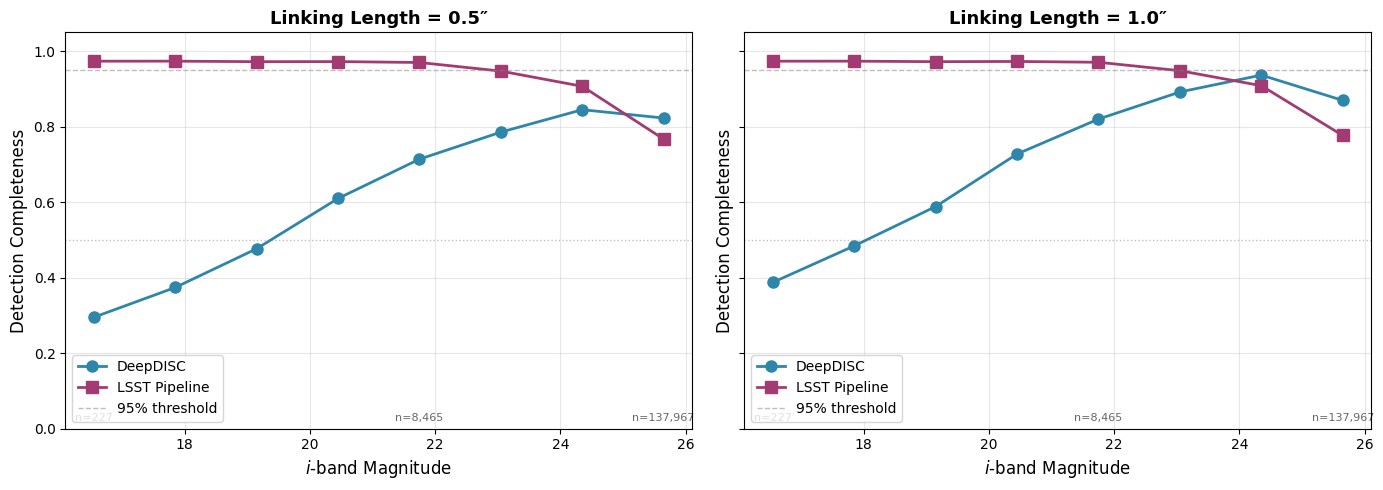

In [48]:
# Recompute with dynamic bins
mag_comp = {}
for ll in ['0.5', '1.0']:
    mag_comp[ll] = {
        'dd': calculate_comp_by_mag(all_matches[ll]['dd'], lsst_truth_cat, 'dd'),
        'lsst': calculate_comp_by_mag(all_matches[ll]['lsst'], lsst_truth_cat, 'lsst')
    }

plot_completeness_vs_magnitude(mag_comp)

# Completeness by Scenario
Calculate completeness separately for isolated systems vs blended systems and break down blended systems by their classification outcomes.

In [19]:
def calculate_comp_by_scenario(object_matches, group_classifications, prefix='dd'):
    """
    Calculate completeness separately for isolated vs blended systems.
    
    Args:
        object_matches: DataFrame with object-level match records
        group_classifications: DataFrame with group-level classifications
        prefix: 'dd' or 'lsst'
    
    Returns:
        dict: Completeness statistics by scenario
    """
    final_col = f'{prefix}_final'
    # Filter to truth objects only
    truth_matches = object_matches[object_matches['truth_row_idx'] != -1].copy()
    # Drop duplicates to get unique truth objects
    truth_matches_unique = truth_matches.drop_duplicates(subset='truth_row_idx')
    # Join with group classifications
    matches_with_groups = truth_matches_unique.merge(
        group_classifications[[final_col, 'n_truth']],
        left_on='group_id',
        right_index=True,
        how='left'
    )
    results = {}
    # Overall
    results['overall'] = {
        'n_total': len(matches_with_groups),
        'n_matched': matches_with_groups['matched'].sum(),
        'completeness': matches_with_groups['matched'].sum() / len(matches_with_groups)
    }    
    # Isolated (1 truth object)
    isolated_mask = matches_with_groups['n_truth'] == 1
    if isolated_mask.any():
        isolated_data = matches_with_groups[isolated_mask]
        results['isolated'] = {
            'n_total': len(isolated_data),
            'n_matched': isolated_data['matched'].sum(),
            'completeness': isolated_data['matched'].sum() / len(isolated_data)
        }
    
    # Blended (2+ truth objects)
    blended_mask = matches_with_groups['n_truth'] >= 2
    if blended_mask.any():
        blended_data = matches_with_groups[blended_mask]
        results['blended'] = {
            'n_total': len(blended_data),
            'n_matched': blended_data['matched'].sum(),
            'completeness': blended_data['matched'].sum() / len(blended_data)
        }
    # Break down by blend outcome
    blend_outcomes = ['resolved_blend', 'partial_deblend', 'unrec_blend', 
                     'shredded', 'unrec_blend_spurious']
    
    for outcome in blend_outcomes:
        outcome_mask = matches_with_groups[final_col] == outcome
        if outcome_mask.any():
            outcome_data = matches_with_groups[outcome_mask]
            results[outcome] = {
                'n_total': len(outcome_data),
                'n_matched': outcome_data['matched'].sum(),
                'completeness': outcome_data['matched'].sum() / len(outcome_data)
            }
    
    return results

In [21]:
print("COMPLETENESS BY SCENARIO")
scenario_comp = {}

for ll, counts_df in counts.items():
    print(f"Linking Length {ll}\"")
    scenario_comp[ll] = {}
    # DD Completeness by Scenario
    print(f"--- DeepDISC Completeness by Scenario ---")
    dd_scenario = calculate_comp_by_scenario(all_matches[ll]['dd'], counts_df, 'dd')
    scenario_comp[ll]['dd'] = dd_scenario
    
    for scenario, stats in dd_scenario.items():
        print(f"{scenario:20s}: {stats['completeness']:6.2%} ({stats['n_total']:,} truth objects)")
    # LSST Completeness by Scenario
    print(f"\n--- LSST Pipeline Completeness by Scenario ---")
    lsst_scenario = calculate_comp_by_scenario(all_matches[ll]['lsst'], counts_df, 'lsst')
    scenario_comp[ll]['lsst'] = lsst_scenario
    
    for scenario, stats in lsst_scenario.items():
        print(f"{scenario:20s}: {stats['completeness']:6.2%} ({stats['n_total']:,} truth objects)")
    print()
print(f"{'='*80}\n")

COMPLETENESS BY SCENARIO
Linking Length 0.5"
--- DeepDISC Completeness by Scenario ---
overall             : 81.41% (224,192 truth objects)
isolated            : 83.50% (212,002 truth objects)
blended             : 45.04% (12,190 truth objects)
resolved_blend      : 100.00% (332 truth objects)
partial_deblend     : 65.22% (46 truth objects)
unrec_blend         : 49.39% (10,334 truth objects)
shredded            : 100.00% (1,831 truth objects)
unrec_blend_spurious: 50.00% (12 truth objects)

--- LSST Pipeline Completeness by Scenario ---
overall             : 82.82% (224,192 truth objects)
isolated            : 84.86% (212,002 truth objects)
blended             : 47.37% (12,190 truth objects)
resolved_blend      : 100.00% (4 truth objects)
unrec_blend         : 49.31% (11,703 truth objects)
shredded            : 100.00% (34 truth objects)

Linking Length 1.0"
--- DeepDISC Completeness by Scenario ---
overall             : 88.05% (224,192 truth objects)
isolated            : 92.15% (192,

In [51]:
def plot_completeness_by_scenario(scenario_comp, linking_length='1.0'):
    """
    Horizontal stacked bar chart showing matched vs unmatched for each scenario.
    Best for comparing performance across blending conditions.
    """
    ll = linking_length
    dd_data = scenario_comp[ll]['dd']
    lsst_data = scenario_comp[ll]['lsst']
    
    # Prepare data for key scenarios
    scenarios = ['overall', 'isolated', 'blended', 'resolved_blend', 
                 'partial_deblend', 'unrec_blend', 'shredded']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    for idx, (catalog_name, data) in enumerate([('DeepDISC', dd_data), ('LSST Pipeline', lsst_data)]):
        ax = axes[idx]
        
        y_positions = []
        labels = []
        matched_pcts = []
        unmatched_pcts = []
        n_totals = []
        
        for scenario in scenarios:
            if scenario in data:
                stats = data[scenario]
                y_positions.append(len(y_positions))
                labels.append(scenario.replace('_', ' ').title())
                
                matched_pct = 100 * stats['n_matched'] / stats['n_total']
                unmatched_pct = 100 - matched_pct
                
                matched_pcts.append(matched_pct)
                unmatched_pcts.append(unmatched_pct)
                n_totals.append(stats['n_total'])
        
        # Create stacked horizontal bars
        ax.barh(y_positions, matched_pcts, color='#27AE60', label='Matched', height=0.7)
        ax.barh(y_positions, unmatched_pcts, left=matched_pcts, 
                color='#E74C3C', label='Unmatched', height=0.7)
        
        # Add completeness percentages
        for i, (y, matched, total) in enumerate(zip(y_positions, matched_pcts, n_totals)):
            ax.text(matched/2, y, f'{matched:.1f}%', 
                   va='center', ha='center', fontweight='bold', 
                   color='white', fontsize=9)
            ax.text(105, y, f'n={total:,}', va='center', ha='left', fontsize=8)
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Percentage', fontsize=12)
        ax.set_title(f'{catalog_name} (LL={ll}″)', fontsize=13, fontweight='bold')
        ax.set_xlim(0, 120)
        ax.grid(axis='x', alpha=0.3)
        ax.legend(loc='lower right')
        ax.invert_yaxis()  # Most important scenarios at top
    
    plt.tight_layout()
    plt.savefig(f'completeness_by_scenario_ll{ll}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: completeness_by_scenario_ll{ll}.png")

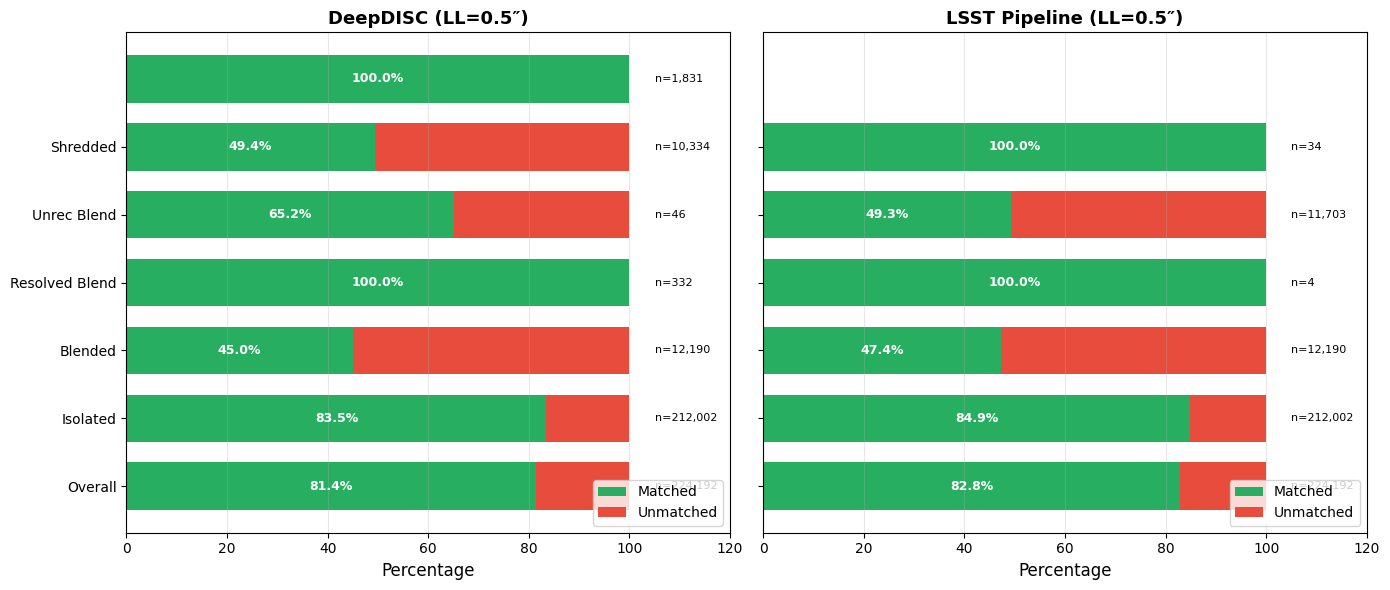

✓ Saved: completeness_by_scenario_ll0.5.png


In [53]:
plot_completeness_by_scenario(scenario_comp, linking_length='0.5')

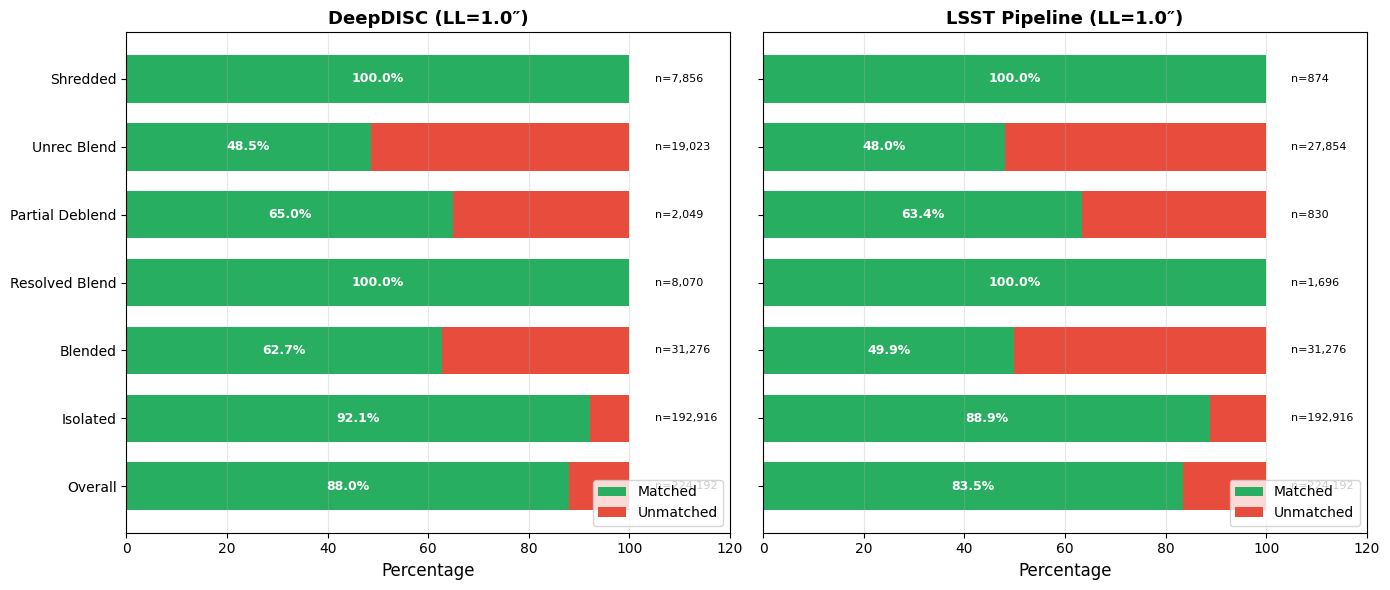

✓ Saved: completeness_by_scenario_ll1.0.png


In [52]:
plot_completeness_by_scenario(scenario_comp, linking_length='1.0')

In [49]:
def plot_completeness_heatmap(object_matches, truth_catalog, group_classifications, 
                               prefix='dd', n_mag_bins=8):
    """
    2D heatmap: magnitude bins × scenario types
    Shows where each catalog excels/struggles
    """
    final_col = f'{prefix}_final'
    
    # Filter and merge
    truth_matches = object_matches[object_matches['truth_row_idx'] != -1].copy()
    truth_matches_unique = truth_matches.drop_duplicates(subset='truth_row_idx')
    
    data = truth_matches_unique.merge(
        truth_catalog[['mag_i']],
        left_on='truth_row_idx',
        right_index=True
    ).merge(
        group_classifications[[final_col, 'n_truth']],
        left_on='group_id',
        right_index=True
    )
    
    # Create magnitude bins
    mag_bins = pd.qcut(data['mag_i'], q=n_mag_bins, duplicates='drop')
    data['mag_bin'] = mag_bins
    
    # Define scenarios
    data['scenario'] = 'Other'
    data.loc[data['n_truth'] == 1, 'scenario'] = 'Isolated'
    data.loc[data[final_col] == 'resolved_blend', 'scenario'] = 'Resolved'
    data.loc[data[final_col] == 'partial_deblend', 'scenario'] = 'Partial'
    data.loc[data[final_col] == 'unrec_blend', 'scenario'] = 'Unrec. Blend'
    
    # Calculate completeness for each cell
    pivot_data = data.groupby(['mag_bin', 'scenario']).agg({
        'matched': ['sum', 'count']
    }).reset_index()
    pivot_data.columns = ['mag_bin', 'scenario', 'matched', 'total']
    pivot_data['completeness'] = pivot_data['matched'] / pivot_data['total']
    
    # Pivot to matrix form
    heatmap_matrix = pivot_data.pivot(index='mag_bin', columns='scenario', values='completeness')
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(heatmap_matrix, annot=True, fmt='.1%', cmap='RdYlGn', 
                vmin=0, vmax=1, cbar_kws={'label': 'Completeness'},
                linewidths=0.5, ax=ax)
    ax.set_xlabel('Scenario Type', fontsize=12)
    ax.set_ylabel('Magnitude Bin ($i$-band)', fontsize=12)
    ax.set_title(f'{prefix.upper()} Completeness Heatmap', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'completeness_heatmap_{prefix}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: completeness_heatmap_{prefix}.png")


/tmp/ipykernel_169907/3832388864.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = data.groupby(['mag_bin', 'scenario']).agg({


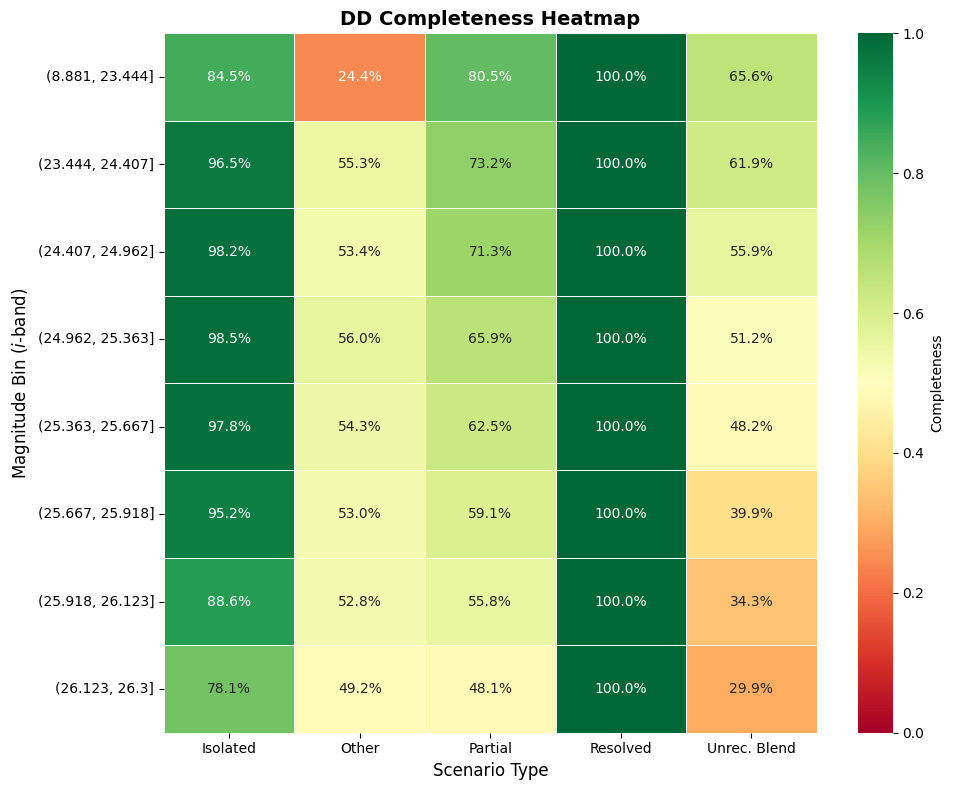

✓ Saved: completeness_heatmap_dd.png


/tmp/ipykernel_169907/3832388864.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = data.groupby(['mag_bin', 'scenario']).agg({


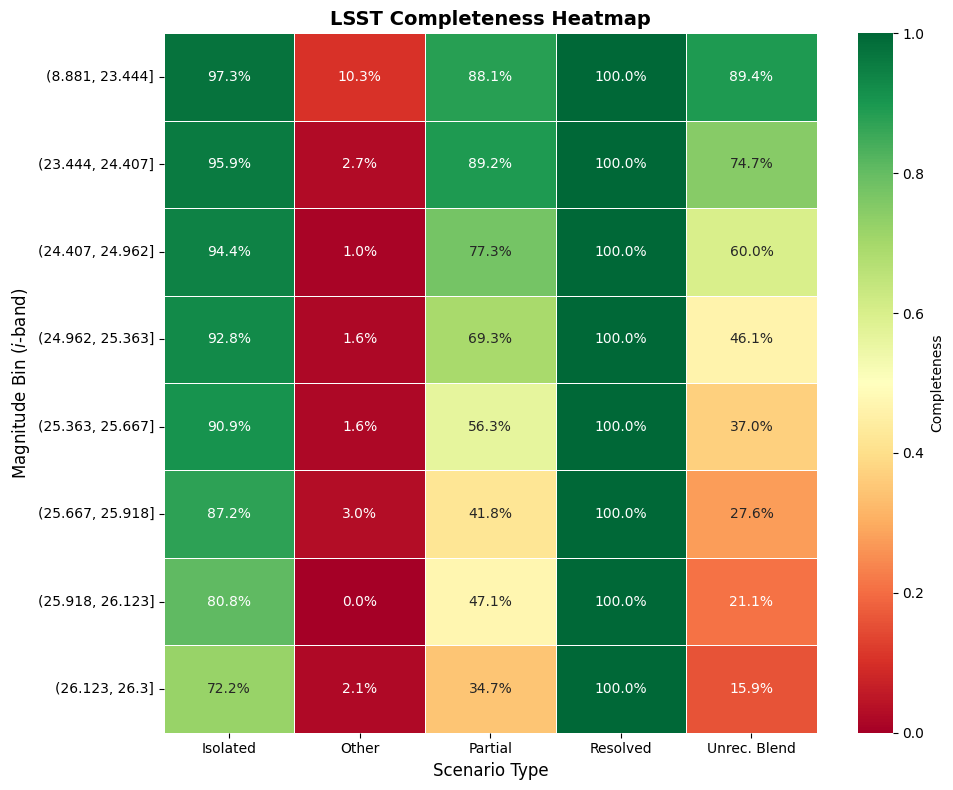

✓ Saved: completeness_heatmap_lsst.png


In [50]:
plot_completeness_heatmap(all_matches['1.0']['dd'], lsst_truth_cat, counts['1.0'], 'dd')
plot_completeness_heatmap(all_matches['1.0']['lsst'], lsst_truth_cat, counts['1.0'], 'lsst')